In [1]:
#import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import tree, preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from itertools import combinations, product
from statistics import mean

First, we will read in and clean the data. 

In [3]:
def clean_data(penguins):
    """
    Cleans the penguins data. 
    """
    # Dropping unneeded columns and rows
    penguins = penguins.drop(['studyName', 'Sample Number', 'Stage', 'Individual ID', 'Clutch Completion', 'Date Egg', 'Comments', 'Region'], axis = 1)
    penguins = penguins.dropna()

    # Recoding and cleaning Sex column
    recode1 = {"MALE"  : 0, "FEMALE" : 1, "." : 2}
    penguins["Sex"] = penguins["Sex"].map(recode1)
    penguins = penguins[penguins['Sex'] != 2]

    # Recoding Island column
    recode2 = {'Biscoe'  : 0, 'Dream' : 1, 'Torgersen'  : 3}
    penguins["Island"] = penguins["Island"].map(recode2)
    
    # Cleaning species column
    penguins["Species"] = penguins["Species"].str.split().str.get(0)
    
    return penguins

In [4]:
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
penguins = pd.read_csv(url)

penguins = clean_data(penguins)

We are now going to find the ideal combination of columns. 

In [4]:
#getting all possible combinations

names = list(penguins.columns)[1:]
combos = list(combinations(names, 3))

combos[1:6]

[('Island', 'Culmen Length (mm)', 'Flipper Length (mm)'),
 ('Island', 'Culmen Length (mm)', 'Body Mass (g)'),
 ('Island', 'Culmen Length (mm)', 'Sex'),
 ('Island', 'Culmen Length (mm)', 'Delta 15 N (o/oo)'),
 ('Island', 'Culmen Length (mm)', 'Delta 13 C (o/oo)')]

In [5]:
#using tree to select cols 
def check_column_score(cols):
    """
    Trains and evaluates a model via cross-validation on the columns of the data
    with selected indices
    """
    T = tree.DecisionTreeClassifier(max_depth = 5)
    return cross_val_score(T, x_train[cols], y_train, cv = 5).mean()  


def test_column_score(tupCol):
    """
    Trains and evaluates a model on the test set using the columns of the data
    with selected indices
    """
    cols = list(tupCol)
    T = tree.DecisionTreeClassifier(max_depth = 5)
    T.fit(x_train[cols], y_train)
    return T.score(x_test[cols], y_test)

In [6]:
# Splitting the data into test and training data

train, test = train_test_split(penguins, test_size = 0.3)
train.shape, test.shape

x_train = train.drop(['Species'], axis = 1)
y_train = train['Species'].values

x_test = test.drop(['Species'], axis = 1)
y_test = test['Species'].values

In [7]:
# Dict with cross value score of each combination 
D = {}

for i in range(len(combos)): 
    cols = list(combos[i])
    x = check_column_score(cols)
    D[i] = x

In [8]:
# Sorts D and shows the top 10 column combinations 
L = list(D.items())
L.sort(key = lambda tup: tup[1], reverse = True)

#show 10 best scores
best = L[0:10]

for where, score in best:
    print("---- " + str(where))
    print(str(combos[where]) + ", Score: " + str(np.round(score, 5)))
    test_score = test_column_score(combos[where])
    print("Test score is: " + str(np.round(test_score, 5)))

---- 0
('Island', 'Culmen Length (mm)', 'Culmen Depth (mm)'), Score: 0.97787
Test score is: 0.9898
---- 25
('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 13 C (o/oo)'), Score: 0.97787
Test score is: 0.95918
---- 27
('Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'), Score: 0.97343
Test score is: 0.90816
---- 4
('Island', 'Culmen Length (mm)', 'Delta 15 N (o/oo)'), Score: 0.97333
Test score is: 0.95918
---- 42
('Culmen Depth (mm)', 'Body Mass (g)', 'Delta 13 C (o/oo)'), Score: 0.96908
Test score is: 0.88776
---- 29
('Culmen Length (mm)', 'Flipper Length (mm)', 'Delta 13 C (o/oo)'), Score: 0.96454
Test score is: 0.89796
---- 1
('Island', 'Culmen Length (mm)', 'Flipper Length (mm)'), Score: 0.96019
Test score is: 0.93878
---- 39
('Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 13 C (o/oo)'), Score: 0.96019
Test score is: 0.88776
---- 48
('Flipper Length (mm)', 'Body Mass (g)', 'Delta 13 C (o/oo)'), Score: 0.96019
Test score is: 0.85714
---- 14
('Island', 'Flipper Length (mm)', 'D

Looking at the above output, we believe that the column combination that has both the best cross evaluation score and the best test score is the combination at the 0 row of combos, which includes Island, Culmen Length, and Culmen Depth as its columns.

In [9]:
# Getting the data that includes just out best columns (which are located at combos[0])

X_train = train[list(combos[0])]
X_test = test[list(combos[0])]

Now, we are going to use a decision tree model to try and predict penguin species. 

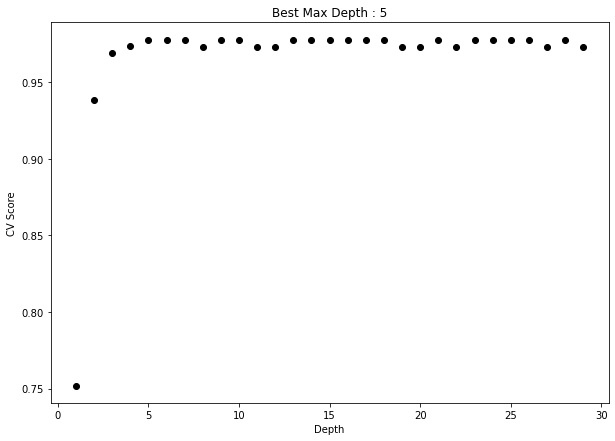

In [10]:
# Figuring out the best max depth for the decisiontree

fig, ax = plt.subplots(1, figsize = (10, 7))

best_score = 0

for d in range(1,30):
    T = tree.DecisionTreeClassifier(max_depth = d)
    cv_score = cross_val_score(T, X_train, y_train, cv=10).mean()
    ax.scatter(d, cv_score, color = "black")
    
    if cv_score > best_score:
        best_depth = d
        best_score = cv_score

l = ax.set(title = "Best Max Depth : " + str(best_depth),
       xlabel = "Depth", 
       ylabel = "CV Score")

In [11]:
# The cross evaluation score gotten from the best max depth is:

best_score

0.9776679841897232

In [12]:
# Fitting the decision tree model

T = tree.DecisionTreeClassifier(max_depth = best_depth)
T.fit(X_train, y_train)
T.score(X_test, y_test)

0.9897959183673469

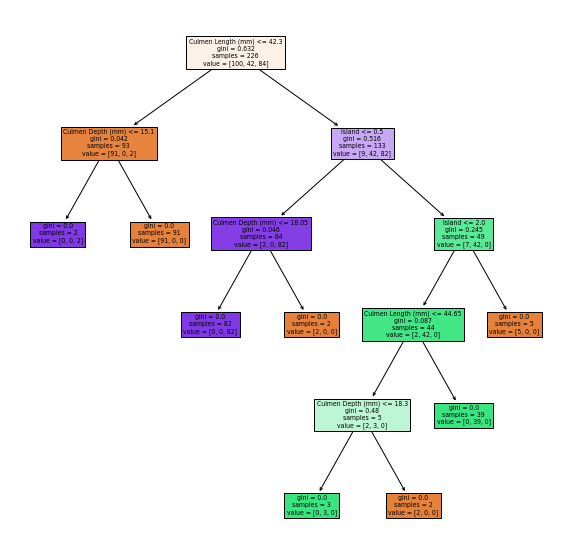

In [13]:
fig, ax = plt.subplots(1, figsize = (10, 10))
p = tree.plot_tree(T, 
                   filled = True, 
                   feature_names = penguins.drop(['Species'], axis = 1).columns)

Now, we are going to use a logistic regression model to try and predict penguin species. 

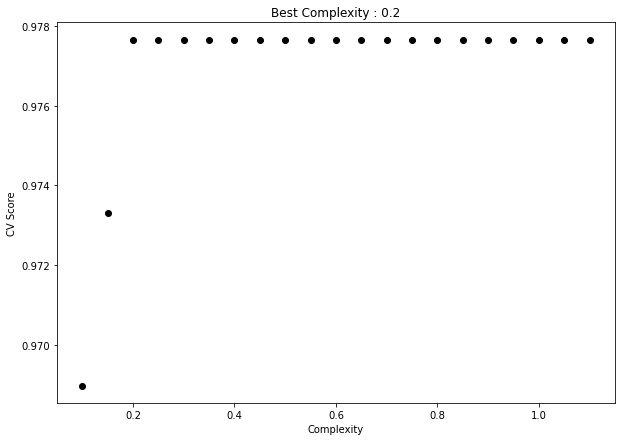

In [14]:
# Testing for best complexity for logistic regresssion

fig, ax = plt.subplots(1, figsize = (10, 7))
lr_best_score = 0

# Comp is short for complexity 
for comp in np.linspace(0.1, 1.1, 21):
    logreg = LogisticRegression(max_iter = 1000, C = comp)
    cv_score = cross_val_score(logreg, X_train, y_train, cv=10).mean()
    ax.scatter(comp, cv_score, color = "black")
    
    if cv_score > lr_best_score:
        best_comp = comp
        lr_best_score = cv_score
    
    
l = ax.set(title = "Best Complexity : " + str(best_comp),
       xlabel = "Complexity", 
       ylabel = "CV Score")

In [31]:
# The cross evaluation score with the best complexity is:
lr_best_score

0.9776679841897232

In [15]:
# Training the logistic regression model

lr = LogisticRegression(max_iter = 1000, C = best_comp)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9489795918367347

Now, we are going to use a multilayer perceptron classifier model to try and predict penguin species. 

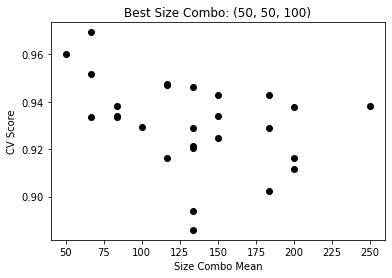

In [26]:
fig, ax = plt.subplots(1)

sizes = [50, 100, 250]
mlp_best_score = 0

for c1, c2, c3 in product(sizes, repeat =  3):
    
    clf = MLPClassifier(hidden_layer_sizes=(c1, c2, c3), max_iter=1000)
    cv_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    ax.scatter(mean([c1, c2, c3]), cv_score, color = "black")
    
    if cv_score > best_score:
        best_depth = (c1, c2, c3)
        mlp_best_score = cv_score
        
        
l = ax.set(title = "Best Size Combo: " + str(best_depth),
xlabel = "Size Combo Mean",
ylabel = "CV Score")

In [32]:
# The cross evaluation score gotten from the best size combo is:

mlp_best_score

0.9693675889328063

In [30]:
# Train an MLPClassifier at best complexity, and evaluate the model on the test set

clf = MLPClassifier(hidden_layer_sizes = best_depth, max_iter=1000).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9591836734693877

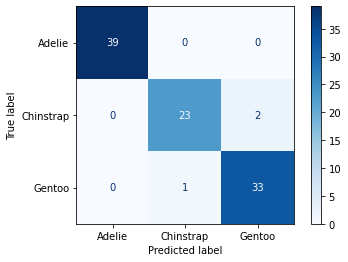

In [19]:
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
c = confusion_matrix(y_train, y_train_pred)

disp = plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues)

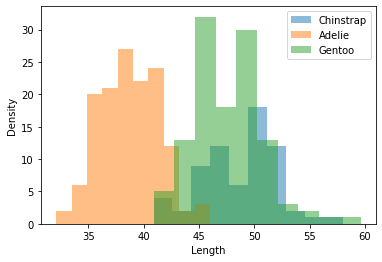

In [25]:
fig, ax = plt.subplots(1)
species = set(penguins['Species'])
ax.set(xlabel = 'Length',
       ylabel = 'Density')

for s in species: 
    i = penguins[penguins['Species'] == s]
    ax.hist(i['Culmen Length (mm)'], label = s, alpha= 0.5)
ax.legend()


""


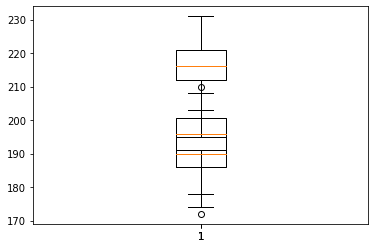

In [6]:
fig, ax = plt.subplots(1)

def plot_box(df):
    ax.boxplot(df['Flipper Length (mm)'])

penguins.groupby("Species").apply(plot_box)

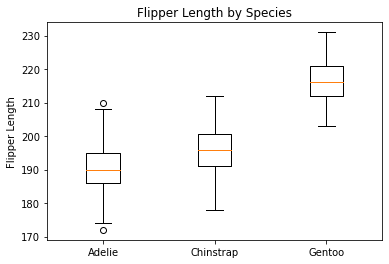

In [39]:
ad = penguins[penguins["Species"] == "Adelie"]["Flipper Length (mm)"] # 190
ch = penguins[penguins["Species"] == "Chinstrap"]["Flipper Length (mm)"] # 2
ge = penguins[penguins["Species"] == "Gentoo"]["Flipper Length (mm)"] # 3, tallest

fig, ax = plt.subplots(1)

bp = ax.boxplot([ad, ch, ge])
l = ax.set(ylabel = "Flipper Length", title = "Flipper Length by Species")
xl = plt.xticks([1, 2, 3], ["Adelie", "Chinstrap", "Gentoo"])

Though we ended up using the column combination of Island, Culmen Length, and Culmen Depth, as the output of the top 10 best column combinations showed, there were other options that we could have chosen. One of the columns that showed up repeatedly as a good predictors of species (that we did not end up using) was Flipper Length. In this boxplot graph, I examined how well Flipper Length can predict Species. As you can see in the results, knowing a penguin's flipper length can likely help in determining whether or not a penguin is of the Gentoo species. However, Flipper Length would not be that helpful in determining whether or not a pegnuin belongs to the Adelie or Chinstrap species.  